step1. import library

In [ ]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, iirnotch
import matplotlib.pyplot as plt
from google.colab import drive
import glob
import os
import time
import tensorflow as tf
from tensorflow import keras
from scipy.signal import butter, filtfilt, stft
from scipy.signal import butter, lfilter, iirnotch



step2. train, test 데이터 불러오기 (.csv file)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_folder_path = '/content/drive/MyDrive/Colab Notebooks/sEMG_data/'
all_train_files = glob.glob(train_folder_path + 'sEMG_data_*.csv')
all_train_files.sort()  # 리스트 정렬


test_folder_path = '/content/drive/MyDrive/Colab Notebooks/sEMG_data_test/'
all_test_files = glob.glob(test_folder_path + 'sEMG_data_*.csv')
all_test_files.sort()   # 리스트 정렬



print(f'Total train data files: {len(all_train_files)}')
print(f'Total test data files: {len(all_test_files)}')



Total train data files: 26
Total test data files: 2


step3. Filtering (Butter_bandpass + Notch filter)

In [ ]:
# function for filtering
def butter_bandpass(lowcut, highcut, fs, order=4):

    nyq = 0.5 * fs  # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    if high >= 1.0:
        high = 0.99

    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_semg_filters(data_array, fs=200):

    # 1. Bandpass Filter
    b_band, a_band = butter_bandpass(20, 95, fs, order=4)
    filtered_data = lfilter(b_band, a_band, data_array)

    # 2. Notch Filter
    b_notch, a_notch = iirnotch(w0=60, Q=30, fs=fs)
    filtered_data = lfilter(b_notch, a_notch, filtered_data)

    return filtered_data

# 3. 센서 이탈 감지 함수
def get_flatline_mask(series, window_size=20):

    is_flat = series.rolling(window=window_size).std().fillna(0) == 0
    is_small = series <= 6
    return is_flat | is_small


def process_and_filter_files(file_list, purpose="Train"):
    processed_list = []
    print(f"--- Processing {purpose} Files ({len(file_list)} files) ---")

    for idx, f_path in enumerate(file_list):
        try:

            df = pd.read_csv(f_path)

            df_filtered = df.copy()


            for ch in target_channels:
                raw_signal = df[ch].values


                filtered_signal = apply_semg_filters(raw_signal, fs=200)

                bad_mask = get_flatline_mask(df[ch], window_size=40)

                filtered_signal[bad_mask] = 0.0

                df_filtered[ch] = filtered_signal


            processed_list.append(df_filtered)


            if idx == 0 or (idx + 1) % 10 == 0:
                print(f"[{idx+1}/{len(file_list)}] Filtering Completed: {f_path.split('/')[-1]}")

        except Exception as e:
            print(f"Error processing {f_path}: {e}")

    return processed_list

In [ ]:
train_data_list = []
test_data_list = []

target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']


train_dfs = process_and_filter_files(all_train_files, purpose="Train")
test_dfs = process_and_filter_files(all_test_files, purpose="Test")

--- Processing Train Files (26 files) ---
[1/26] Filtering Completed: sEMG_data_0.csv
[10/26] Filtering Completed: sEMG_data_17.csv
[20/26] Filtering Completed: sEMG_data_3.csv
--- Processing Test Files (2 files) ---
[1/2] Filtering Completed: sEMG_data_26.csv


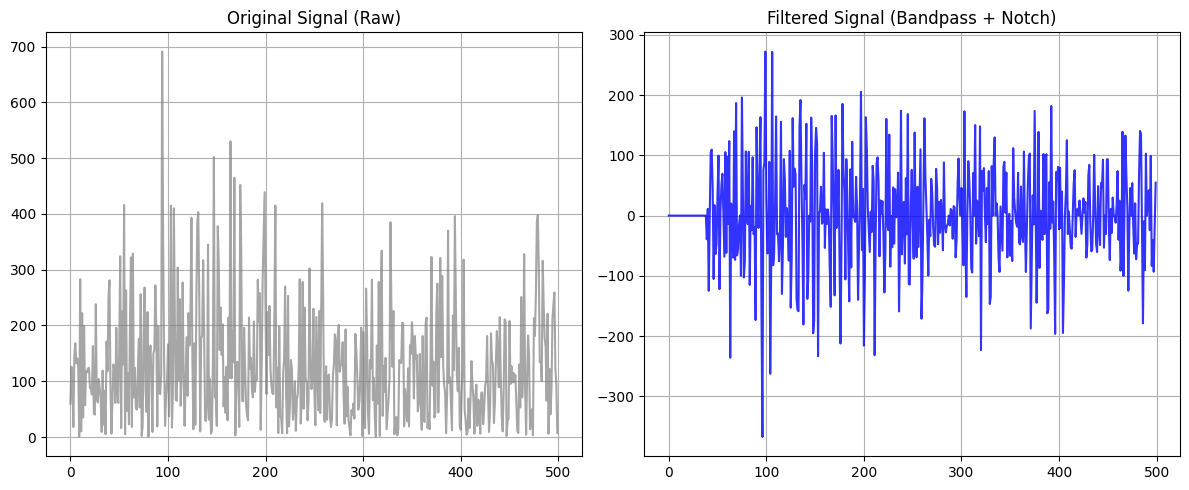

필터링 적용 완료! 데이터가 메모리(train_dfs, test_dfs)에 저장되었습니다.


In [ ]:
# 3. Example plotting
# 1st file 1st channel (Example plot)
if len(train_dfs) > 0:
    original_df = pd.read_csv(all_train_files[0])
    filtered_df = train_dfs[0]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(original_df['Ch1'][:500], label='Original', color='gray', alpha=0.7)
    plt.title("Original Signal (Raw)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(filtered_df['Ch1'][:500], label='Filtered', color='blue', alpha=0.8)
    plt.title("Filtered Signal (Bandpass + Notch)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("필터링 적용 완료! 데이터가 메모리(train_dfs, test_dfs)에 저장되었습니다.")

step4. Normalization (MVC, MinMax, Zscore)

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']
all_train_values = np.concatenate([df[target_channels].values for df in train_dfs])

# 3가지 normalization option
SCALER_TYPE = 'Zscore'  # <-- 'MVC' or 'MinMax' or 'Zscore'

print(f"step4. normalization , Selected Method: {SCALER_TYPE})...")


target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']
all_train_values = np.concatenate([df[target_channels].values for df in train_dfs])


step4. normalization , Selected Method: Zscore)...


In [ ]:
# 1) Z-score Scaling (Standardization)
if SCALER_TYPE == 'Zscore':
    scaler = StandardScaler()
    scaler.fit(all_train_values)

    def apply_normalization(data_values, scaler_obj):
        return scaler_obj.transform(data_values)

# 2) Min-Max Scaling
elif SCALER_TYPE == 'MinMax':
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(all_train_values)

    def apply_normalization(data_values, scaler_obj):
        return scaler_obj.transform(data_values)


# 3) MVC (Maximum Voluntary Contraction) Scaling

elif SCALER_TYPE == 'MVC':

    mvc_values = np.max(np.abs(all_train_values), axis=0)

    mvc_values = mvc_values + 1e-8

    print(f"  -> Computed MVC (Max Abs) per channel: {mvc_values}")


    scaler = mvc_values

    def apply_normalization(data_values, scaler_obj):

        return data_values / scaler_obj

else:
    raise ValueError("SCALER_TYPE을 확인하세요! ('MVC', 'MinMax', 'Zscore')")

print(" Scaler 학습(준비) 완료.")

 -> Scaler 학습(준비) 완료.


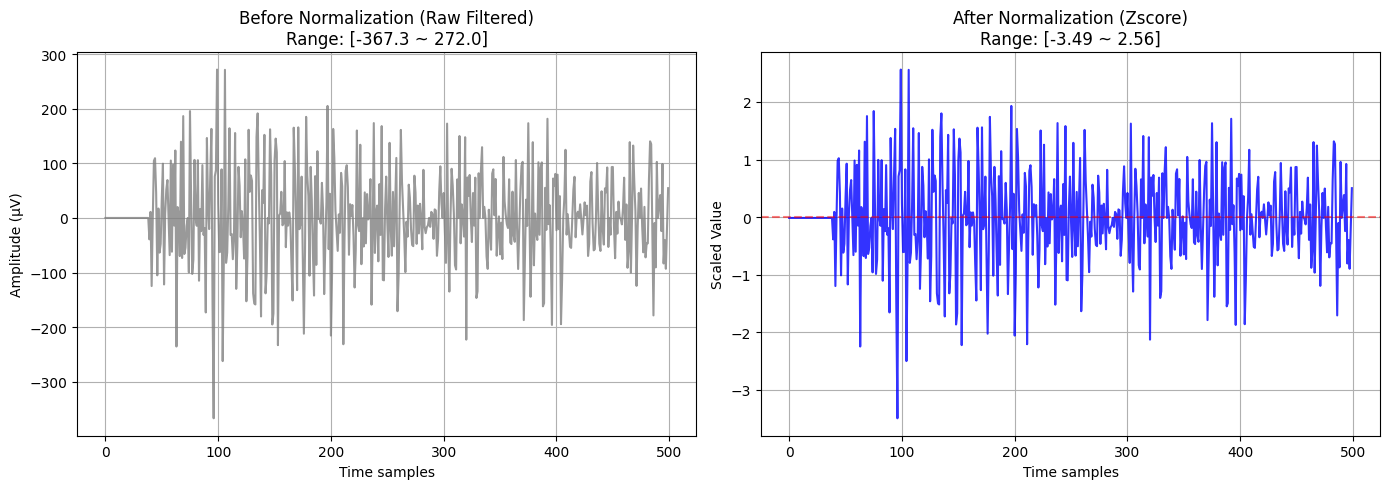

확인: 데이터의 패턴(모양)은 그대로 유지되면서, Y축 값의 범위만 변함.


In [ ]:
import matplotlib.pyplot as plt

example_df = train_dfs[0]
raw_data = example_df['Ch1'].values[:500] # 앞부분 500개 샘플만 (2.5초) sample만 예시로 보여주기


norm_data_all = apply_normalization(example_df[target_channels].values, scaler)
norm_data_ch1 = norm_data_all[:500, 0]


plt.figure(figsize=(14, 5))

# Before normalization
plt.subplot(1, 2, 1)
plt.plot(raw_data, color='gray', alpha=0.8)
plt.title(f"Before Normalization (Raw Filtered)\nRange: [{raw_data.min():.1f} ~ {raw_data.max():.1f}]")
plt.xlabel("Time samples")
plt.ylabel("Amplitude (μV)")
plt.grid(True)

# After normalization
plt.subplot(1, 2, 2)
plt.plot(norm_data_ch1, color='blue', alpha=0.8)
plt.title(f"After Normalization ({SCALER_TYPE})\nRange: [{norm_data_ch1.min():.2f} ~ {norm_data_ch1.max():.2f}]")
plt.xlabel("Time samples")
plt.ylabel("Scaled Value")
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"확인: 데이터의 패턴(모양)은 그대로 유지되면서, Y축 값의 범위만 변함.")


step5.Windowing

In [ ]:
def create_windows_from_list(df_list, scaler_obj, window_size=40, overlap=20):
    X_list = []
    y_list = []
    step = window_size - overlap

    for df in df_list:
        raw_vals = df[target_channels].values
        data_norm = apply_normalization(raw_vals, scaler_obj)

        labels = df['label'].values

        if len(data_norm) < window_size:
            continue

        for i in range(0, len(data_norm) - window_size + 1, step):
            window_data = data_norm[i : i + window_size]
            window_label = labels[i + window_size - 1]

            X_list.append(window_data)
            y_list.append(window_label)

    return np.array(X_list), np.array(y_list)

In [ ]:
X_train, y_train = create_windows_from_list(train_dfs, scaler, window_size=40, overlap=20)
X_test, y_test = create_windows_from_list(test_dfs, scaler, window_size=40, overlap=20)

# label encoding  (1~5 -> 0~4)
y_train = y_train - 1
y_test = y_test - 1

print(f" -> Train Data Shape: X={X_train.shape}, y={y_train.shape}")
print(f" -> Test Data Shape : X={X_test.shape}, y={y_test.shape}")


 -> Train Data Shape: X=(14730, 40, 4), y=(14730,)
 -> Test Data Shape : X=(1461, 40, 4), y=(1461,)


LV5(실패지점 class) 제외하기

In [ ]:
print(f"제거 전 데이터 개수: {len(y_train)}")

# 1. Train 데이터 필터링
mask_train = y_train < 4  # 0, 1, 2, 3만 True (4는 False)
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# 2. Test 데이터 필터링
mask_test = y_test < 4
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print(f"Lv5 제거 후 Train 개수: {len(y_train)}")
print(f"Lv5 제거 후 Test 개수: {len(y_test)}")


제거 전 데이터 개수: 14730
Lv5 제거 후 Train 개수: 14523
Lv5 제거 후 Test 개수: 1449


으아아아아아아 일단 전처리(노이즈 제거 + 센서 때진 부분 0으로 처리 + 정규화) 끝

step6. AI model formation (1D-CNN)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
input_shape = (40, 4)  # (Window_Size, Channels)
num_classes = 4        # 0,1,2,3,4 (총 5단계) 에서 0,1,2,3 총 4단계

model = Sequential([
    # Layer 1
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Layer 2
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Layer 3
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),


    # Fully Connected Layer (Classifier)
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# 2. compile
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 10, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,852 (1.74 MB)

 Trainable params: 453,956 (1.73 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
print("데이터 셔플링 완료")


✅ 데이터 셔플링 완료!


In [ ]:
# training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)


Epoch 1/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - accuracy: 0.2775 - loss: 2.1143 - val_accuracy: 0.3115 - val_loss: 1.6573 - learning_rate: 5.0000e-04
Epoch 2/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2965 - loss: 1.4163 - val_accuracy: 0.3377 - val_loss: 1.5720 - learning_rate: 5.0000e-04
Epoch 3/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3406 - loss: 1.3626 - val_accuracy: 0.3504 - val_loss: 1.4710 - learning_rate: 5.0000e-04
Epoch 4/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3432 - loss: 1.3474 - val_accuracy: 0.3442 - val_loss: 1.4460 - learning_rate: 5.0000e-04
Epoch 5/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3610 - loss: 1.3288 - val_accuracy: 0.3601 - val_loss: 1.4229 - learning_rate: 5.0000e-04
Epoch 6/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3681 - loss: 1.3213 - val_accuracy: 0.3597 - val_loss: 1.4131 - learning_rate: 5.0000e-04
Epoch 7/100
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - a

step7. evaluation

★ Final Test Accuracy: 31.68%


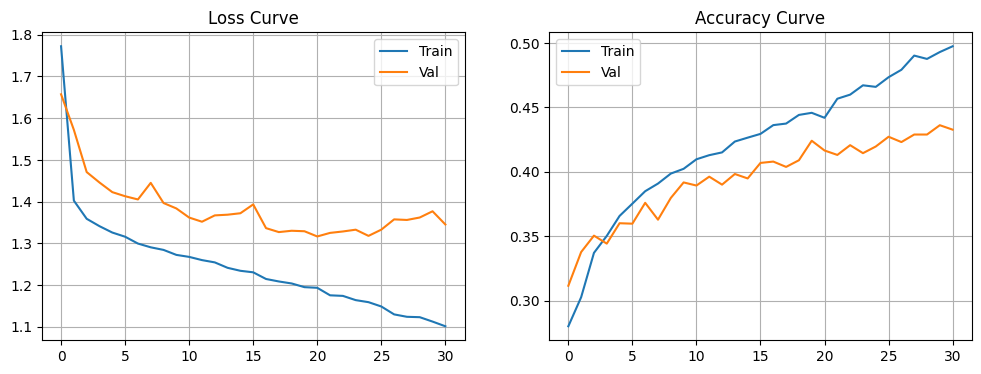

46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


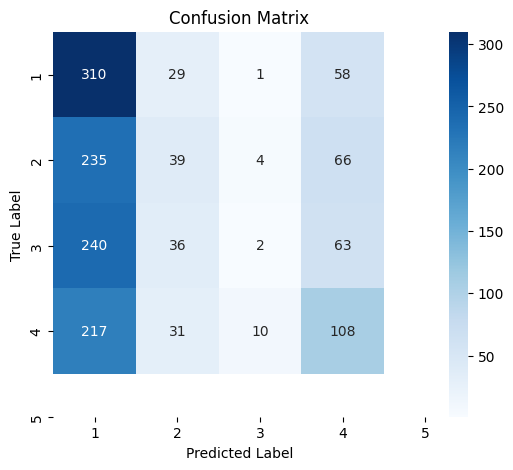


Classification Report:
              precision    recall  f1-score   support

         Lv1       0.31      0.78      0.44       398
         Lv2       0.29      0.11      0.16       344
         Lv3       0.12      0.01      0.01       341
         Lv4       0.37      0.30      0.33       366

    accuracy                           0.32      1449
   macro avg       0.27      0.30      0.24      1449
weighted avg       0.27      0.32      0.25      1449



In [ ]:
# 1. Accuracy evaluation
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f" Final Test Accuracy: {test_acc*100:.2f}%")

# 2.  (Loss & Accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)
plt.show()

# 3. Confusion Matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4. 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Lv1', 'Lv2', 'Lv3', 'Lv4'])) # LV5 제외